# ****  OLG ATAC subset regional analysis ****

In [21]:
# Run TFIDF Normalization
def runTfIdf(
    adata_atac, 
    scale_factor=1e4, 
    copy=False):
    """
    TF-IDF normalization according to MultiVelo
    """
    npeaks = adata_atac.X.sum(1)
    npeaks_inv = scipy.sparse.csr_matrix(1.0/npeaks)
    tf = adata_atac.X.multiply(npeaks_inv)
    idf = scipy.sparse.diags(np.ravel(adata_atac.X.shape[0] / adata_atac.X.sum(0))).log1p()
    if copy:
        adata_atac_copy = adata_atac.copy()
        adata_atac_copy.X = tf.dot(idf) * scale_factor
        return adata_atac_copy
    else:
        adata_atac.X = tf.dot(idf) * scale_factor

## Run SVD
def runSVD(
    adata_atac, 
    algorithm="arpack", 
    n_components=30, 
    pca_key="X_pca"):
    random_state = np.random.RandomState(0)
    random_state = check_random_state(random_state)
    pca_ = TruncatedSVD(n_components=n_components, random_state=random_state, algorithm=algorithm)
    X_pca = pca_.fit_transform(adata_atac.X)
    
    adata_atac.obsm[pca_key] = X_pca
    adata_atac.uns["pca"] = {}
    adata_atac.uns["pca"]["params"] = {"zero_center": False}
    adata_atac.uns["pca"]["variance"] = pca_.explained_variance_
    adata_atac.uns["pca"]["variance_ratio"] = pca_.explained_variance_ratio_
    adata_atac.varm["PCs"] = pca_.components_.T

## Flatten a list of lists
def flatten(t):
    return [i for s in t for i in s]

## Select top variable features across each cluster 
def selectVarFeatures(adata_atac, use_key=None, min_cells_per_cluster=500):
    var_features = []
    for cluster in set(adata_atac.obs[use_key]):
        minidata = adata_atac[adata_atac.obs[use_key]==cluster].copy()
        if minidata.shape[0] < min_cells_per_cluster:
            continue
        else:
            n_cells = np.array(np.sum(minidata.layers["raw_counts"], axis=0).T)
            z_score_acc = scipy.stats.zscore(n_cells)
            minidata.var["abs_z"] = [abs(x) for x in np.concatenate(z_score_acc).ravel().tolist()]
            var_features.append(minidata[:,minidata.var["abs_z"]>1.65].var_names.tolist())

    var_features = list(set(flatten(var_features)))
    return adata_atac[:,var_features].copy()

def iterativeLSI(
    adata_atac,
    n_pc_comps=30,
    n_iters=3,
    cluster_res=0.5,
    distance_metric="cosine",
    clustering_method="leiden",
    save_iter_umaps=False,
    file_format = "png",
    use_binary_counts=False,
    min_cells_per_cluster=500):
    """
    Run iterative LSI on the AnnData object. 
    TFIDF -> SVD -> KNN --> Cluster --> variable_features --> TFIDF ... 
    """
    
    #check layers in adata
    if "raw_counts" not in adata_atac.layers:
        print("Raw Counts not saved. Saving now.")
        if np.max(adata_atac.X) > 1:
            adata_atac.layers["raw_counts"] = adata_atac.X.copy()
        else:
            raise Exception("Raw counts missing")
        if use_binary_counts:
            print("Using binary counts. Binarizing matrix.")
            epi.pp.binarize(adata_atac)
            adata_atac.layer["binary_counts"] = adata_atac.X.copy()
        else:
            print("Not using binary counts for LSI. Proceeding with raw counts.")
    

    adata_i = adata_atac.copy()

    print(f"Total number of iterations: {n_iters}")
    for i in range(1, n_iters+1):
        print(f"**** Running iteration {i}")
        print(f"** Using {str(adata_i.shape[-1])} features")

        ## run LSI
        print(" Normalizing with TFIDF")
        runTfIdf(adata_i)
        print(" Running SVD")
        runSVD(adata_i, n_components=n_pc_comps)

        
        ## build kNN graph
        print(" Building graph")
        sc.pp.neighbors(adata_i,  n_pcs=n_pc_comps, metric=distance_metric)
        
        print(" Clustering")
        ## Clustering
        if clustering_method == "louvain":
            cluster_key = "louvain_iter_"
            cluster_key_added = cluster_key + str(i)
            try:
                sc.tl.louvain(adata_i, resolution=cluster_res, key_added=cluster_key_added)
            except:           ## Not sure what exception to catch here --> check this!
                raise Exception("Can't run -  Fix the louvain dependency issue first")
        elif clustering_method == "leiden":
            print(f" Using Leiden algorithm")
            cluster_key = "leiden_iter_"
            cluster_key_added = cluster_key + str(i)
            sc.tl.leiden(adata_i, resolution=cluster_res, key_added=cluster_key_added)
        
        print(f" Saving cluster labels from this round")
        ## add clustering result to adata_atac
        adata_atac.obs[cluster_key_added] = adata_i.obs[cluster_key_added].copy()


        if i != n_iters:
            ## save intermediate UMAP if needed
            if save_iter_umaps:
                print(f" Saving iteration {i} umap")
                sc.tl.umap(adata_i)
                sc.pl.umap(adata_i, color=cluster_key_added, show=True)
            
            ## select variable features from original adata_atac dataset
            print("** Selecting variable features")
            adata_i = selectVarFeatures(adata_atac, use_key=cluster_key_added,
                                        min_cells_per_cluster=min_cells_per_cluster)
            adata_i.X = adata_i.layers["raw_counts"].copy()

        else: ## Final iteration
            print(f" Saving UMAP from final iteration")
            sc.tl.umap(adata_i)
            sc.pl.umap(adata_i, color=cluster_key_added)
            #adata_i.layers["norm_counts"] = adata_i.X.copy()
            #adata_atac.layers = adata_i.layers.copy()
            #print("Storing normalized counts from final iteration")
            adata_atac.obsp = adata_i.obsp.copy()
            adata_atac.uns = adata_i.uns.copy()
            adata_atac.obsm = adata_i.obsm.copy()
            print("****** Finished iterative clustering ******")
            
            

In [1]:
import os
import csv
import scipy
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi
#import magic
#import scprep
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import check_random_state
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import warnings
style.use("default")
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = "retina"
os.chdir("/data/proj/GCB_MK/CZI/episcanpy_analysis/AGG_ATAC_210218/PIPELINE/")

In [ ]:
adata_main = ad.read("data/220906_2kb_matrix_iterativeLSI_results_hiQ_annotated.h5ad")

In [ ]:
oligodata = adata_main[adata_main.obs.annot_rough.isin(["OPC","OLIGO1","OLIGO2","OLIGO3"])]
#adata = adata[adata.obs.Tissue!="CB"]

In [2]:
ctype = "OLG"
modality = "ATAC"

In [13]:
adata = ad.read("data/matrices/221210_5kb_matrix_OLG_hiQ_annotated.h5ad")

In [14]:
adata

AnnData object with n_obs × n_vars = 55582 × 570241
    obs: 'NGI_ID', 'NGS_BATCH', 'caseNO', 'Tissue', 'Sex', 'Age', 'PMI', '10X_BATCH', 'nb_features', 'log_nb_features', 'leiden_iter_1', 'leiden_iter_2', 'leiden_iter_3', 'leiden_iter_4', 'annot_rough', 'doublet_scores', 'predicted_doublets', 'ArchR_id', 'is_ArchR_hiQ'
    var: 'n_counts'

In [15]:
min_features_per_cell = 10  # min feature cutoff 
#max_features_per_cell = 10000 
top_n_features = 50000      # top N features to keep <- lower values will reduce the overlap between modalities

In [7]:
del adata.obs["nb_features"]
del adata.obs["log_nb_features"]

In [16]:
min_cells = np.sort(adata.var["n_counts"])[-(top_n_features)]
adata = adata[:, adata.var["n_counts"] >= min_cells].copy()

In [18]:
adata.obs["log_nb_features"] = [np.log10(x) for x in adata.obs["nb_features"]]

In [ ]:
adata

In [19]:
adata.obs["olg_type"] = ["OPC" if x=="OPC" else "MOL" for x in adata.obs.annot_rough]

In [20]:
if ctype=="OPC":
    adata = adata[adata.obs.annot_rough=="OPC"]
elif ctype=="MOL":
    adata = adata[adata.obs.annot_rough!="OPC"]

In [22]:
adata.layers["raw_counts"] = adata.X.copy()
runTfIdf(adata)
adata.layers["normalized_counts"]  = adata.X.copy()

AnnData object with n_obs × n_vars = 55582 × 50014
    obs: 'NGI_ID', 'NGS_BATCH', 'caseNO', 'Tissue', 'Sex', 'Age', 'PMI', '10X_BATCH', 'leiden_iter_1', 'leiden_iter_2', 'leiden_iter_3', 'leiden_iter_4', 'annot_rough', 'doublet_scores', 'predicted_doublets', 'ArchR_id', 'is_ArchR_hiQ', 'olg_type', 'n_counts', 'log_nb_features'
    var: 'n_counts'
    uns: 'rank_features_groups'
    layers: 'normalized_counts'

In [73]:
epi.tl.rank_features(adata, groupby="Tissue", use_raw=False, n_features=adata.X.shape[1])
subresult = adata.uns["rank_features_groups"]
subgroups = subresult["names"].dtype.names

#opc_csc_markers = subresult["names"]["CSC"][:10].tolist()
#opc_ba_markers = subresult["names"]["BA4"][:10].tolist()

opc_csc_markers = subresult["names"]["CSC"][:10].tolist()
opc_ba_markers = subresult["names"]["BA4"][:10].tolist()

In [74]:
opc_csc_var_peaks = pd.DataFrame(
        {key: subresult[key]["CSC"] 
         for key in ["names", "logfoldchanges", "pvals", "pvals_adj"]})

opc_ba_var_peaks = pd.DataFrame(
        {key: subresult[key]["BA4"] 
         for key in ["names", "logfoldchanges", "pvals", "pvals_adj"]})

In [75]:
opc_csc_var_peaks_logfold = opc_csc_var_peaks.sort_values(by=["logfoldchanges"], ascending=False).head(20).names.tolist()
opc_ba_var_peaks_logfold = opc_ba_var_peaks.sort_values(by=["logfoldchanges"], ascending=False).head(20).names.tolist()
####     plots Trackplot in jupyter
#ax = sc.pl.tracksplot(adata, opc_csc_var_peaks_logfold, groupby='Tissue')
#ax = sc.pl.tracksplot(adata, opc_ba_var_peaks_logfold, groupby='Tissue')

### Up and Down in BA4

In [26]:
opc_ba_var_peaks["Tissue"] = f"Up_BA4_{ctype}"
opc_ba_var_peaks.loc[opc_ba_var_peaks.logfoldchanges<0,"Tissue"] = f"Down_BA4_{ctype}"
opc_ba_var_peaks["-log10(pval_adj)"] = [-1*np.log10(x) for x in opc_ba_var_peaks.pvals_adj]
opc_ba_var_peaks = opc_ba_var_peaks.rename(columns={"logfoldchanges":"logFC"})
opc_ba_var_peaks["significant"] = False
opc_ba_var_peaks.loc[(opc_ba_var_peaks["-log10(pval_adj)"] >= 3) & ((opc_ba_var_peaks["logFC"] >= 1.5) | (opc_ba_var_peaks["logFC"] <= -1.5)), "significant"] = True
opc_ba_var_peaks.loc[opc_ba_var_peaks.significant==False, "Tissue"] = "NS"

#opc_ba_var_peaks.loc[opc_ba_var_peaks.logFC >= 10, "logFC"] = 10 #<- leftshifts the outliers
#opc_ba_var_peaks.loc[opc_ba_var_peaks.logFC <= -10, "logFC"] = -10 #<- leftshifts the outliers
#opc_ba_var_peaks.loc[opc_ba_var_peaks["-log10(pval_adj)"] >= 100, "-log10(pval_adj)"] = 100 #<- leftshifts the outliers

#plt.figure(figsize=(10,10))
#ax= sns.scatterplot(data=opc_ba_var_peaks, x="logFC", y="-log10(pval_adj)", s=3, alpha=0.6, hue="Tissue", palette=["green","grey","blue"]);
#plt.axhline(y=3, alpha=0.1, ls="--", color='black', linewidth=0.9); ## pval_adj cutoff = 0.001
#plt.axvline(x=1.5, alpha=0.1, ls="--", color='black', linewidth=0.9);
#plt.axvline(x=-1.5, alpha=0.1, ls="--", color='black', linewidth=0.9);

### Up and Down in CSC

In [ ]:
opc_csc_var_peaks["Tissue"] = f"Up_CSC_{ctype}"
opc_csc_var_peaks.loc[opc_csc_var_peaks.logfoldchanges<0,"Tissue"] = f"Down_CSC_{ctype}"
opc_csc_var_peaks["-log10(pval_adj)"] = [-1*np.log10(x) for x in opc_csc_var_peaks.pvals_adj]
opc_csc_var_peaks = opc_csc_var_peaks.rename(columns={"logfoldchanges":"logFC"})
opc_csc_var_peaks["significant"] = False
opc_csc_var_peaks.loc[(opc_csc_var_peaks["-log10(pval_adj)"] >= 3) & ((opc_csc_var_peaks["logFC"] >= 1.5) | (opc_csc_var_peaks["logFC"] <= -1.5)), "significant"] = True
opc_csc_var_peaks.loc[opc_csc_var_peaks.significant==False, "Tissue"] = "NS"

#opc_csc_var_peaks.loc[opc_csc_var_peaks.logFC >= 10, "logFC"] = 10 #<- leftshifts the outliers
#opc_csc_var_peaks.loc[opc_csc_var_peaks.logFC <= -10, "logFC"] = -10 #<- leftshifts the outliers
#opc_csc_var_peaks.loc[opc_csc_var_peaks["-log10(pval_adj)"] >= 100, "-log10(pval_adj)"] = 100 #<- leftshifts the outliers

plt.figure(figsize=(3,3))
ax= sns.scatterplot(data=opc_csc_var_peaks, x="logFC", y="-log10(pval_adj)", s=3, alpha=0.6, hue="Tissue", palette=["green","grey","blue"]);
plt.axhline(y=3, alpha=0.1, ls="--", color='black', linewidth=0.9); ## pval_adj cutoff = 0.001
plt.axvline(x=1.5, alpha=0.1, ls="--", color='black', linewidth=0.9);
plt.axvline(x=-1.5, alpha=0.1, ls="--", color='black', linewidth=0.9);

#for i in range(8):
#    plt.annotate(opc_csc_var_peaks.names[i], (opc_csc_var_peaks["logFC"][i], opc_csc_var_peaks["-log10(pval_adj)"][i] + 0.2), size=7)


ax.get_legend().remove()

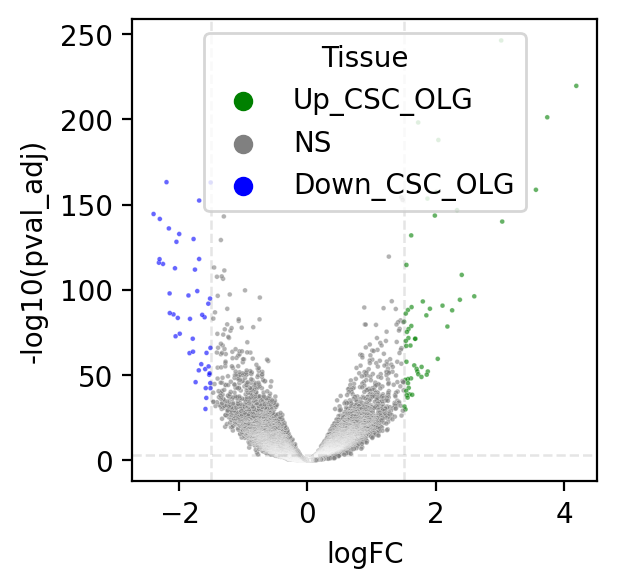

In [77]:
plt.figure(figsize=(3,3))
ax= sns.scatterplot(data=opc_csc_var_peaks, x="logFC", y="-log10(pval_adj)", s=3, alpha=0.6, hue="Tissue", palette=["green","grey","blue"]);
plt.axhline(y=3, alpha=0.1, ls="--", color='black', linewidth=0.9); ## pval_adj cutoff = 0.001
plt.axvline(x=1.5, alpha=0.1, ls="--", color='black', linewidth=0.9);
plt.axvline(x=-1.5, alpha=0.1, ls="--", color='black', linewidth=0.9);

ax.get_legend().remove()

## Up in CSC vs Up in BA4

In [28]:
df_1 = opc_csc_var_peaks[opc_csc_var_peaks.logFC>=0]
df_2 = opc_ba_var_peaks[opc_ba_var_peaks.logFC>=0]
df_2["logFC"] = -1*df_2.logFC
df_3 = df_1.append(df_2).sort_values(by="logFC", ascending=False)
df_3.index = [x for x in range(len(df_3))]

df_3.loc[df_3.logFC >= 10, "logFC"] = 10 #<- leftshifts the outliers
df_3.loc[df_3.logFC <= -10, "logFC"] = -10 #<- leftshifts the outliers
#df_3.loc[df_3["-log10(pval_adj)"] >= 100, "-log10(pval_adj)"] = 100 #<- leftshifts the outliers


#plt.figure(figsize=(10,10))
#ax= sns.scatterplot(data=df_3, x="logFC", y="-log10(pval_adj)", s=3, alpha=0.6, hue="Tissue", palette=["green","grey","blue"]);
#plt.axhline(y=3, alpha=0.1, ls="--", color='black', linewidth=0.9); ## pval_adj cutoff = 0.001
#plt.axvline(x=1.5, alpha=0.1, ls="--", color='black', linewidth=0.9);
#plt.axvline(x=-1.5, alpha=0.1, ls="--", color='black', linewidth=0.9);

In [44]:
sig_df = df_3.loc[df_3["significant"]==True]
sig_df = sig_df.sort_values(by=["logFC"], ascending=False)

df_a = sig_df.names.str.split("_", expand=True)
df_a["peak_name"] = sig_df["names"]
df_a["name"] = ["peak"+str(x) for x in range(len(df_a))]
df_a["strand"] = ["+" for x in range(len(df_a))]
df_a["logFC"] = sig_df["logFC"]
df_a["pvals"] = sig_df["pvals"]
df_a["pvals_adj"] = sig_df["pvals"]
df_a["Tissue"] = sig_df["Tissue"]

#df_a.to_csv(f"/data/proj/GCB_MK/scCT/nanoCT_EAE/data/variable_peaks/sig_diff_peaks_{ctype}_TRUE_CSCvsBA4_ATAC.bed", header=False, index=False, sep="\t")

## !chdir /data/proj/GCB_MK/scCT/nanoCT_EAE/data/variable_peaks
## !sh annotate_peaks_homer_2.sh sig_diff_peaks_{ctype}_CSCvsBA4_ATAC.bed
## load in output from 

In [68]:
df_3.to_csv(f"/data/proj/GCB_MK/scCT/nanoCT_EAE/data/variable_peaks/ALL_diff_peaks_{ctype}_TRUE_CSCvsBA4_ATAC.bed", header=True, index=False, sep="\t")

In [31]:
plt.rcParams["figure.figsize"] = [3.2,2.4] #[6.4,4.8]

In [54]:
df_3["is_hox"] = [True if x.startswith("H") else False for x in df_3["hox_name"]]
df_3.sort_values(by="is_hox")

,names,logFC,pvals,pvals_adj,Tissue,-log10(pval_adj),significant,Gene_Name,hox_name,fox_name,is_hox
24631,chr4_7205000_7210000,0.000115,9.988150e-01,9.990547e-01,NS,0.000411,False,,,,False
32836,chr13_24080000_24085000,-0.127908,1.469976e-01,1.902922e-01,NS,0.720579,False,,,,False
32837,chr22_23070000_23075000,-0.127918,4.328730e-04,9.036903e-04,NS,3.043980,False,,,,False
32838,chr4_8010000_8015000,-0.127928,2.667185e-02,4.058926e-02,NS,1.391589,False,,,,False
32839,chr3_99875000_99880000,-0.127933,6.662075e-02,9.330637e-02,NS,1.030089,False,,,,False
...,...,...,...,...,...,...,...,...,...,...,...
14,chr2_176130000_176135000,2.256855,1.310364e-91,9.929783e-89,Up_CSC_OLG,88.003060,True,HOXD8,HOXD8,,True
15,chr2_176155000_176160000,2.182716,5.625153e-82,3.125960e-79,Up_CSC_OLG,78.505017,True,HOXD3,HOXD3,,True
44,chr7_27160000_27165000,1.576614,1.824268e-80,9.604098e-78,Up_CSC_OLG,77.017543,True,HOXA9,HOXA9,,True
7,chr7_27155000_27160000,3.562610,5.579733e-163,2.146652e-159,Up_CSC_OLG,158.668238,True,HOXA7,HOXA7,,True


In [65]:
df_3.hox_name.value_counts()

            49249
HOXA7           2
HOXA4           1
HOXA2           1
HOXB-AS1        1
HOXA5           1
HOXB2           1
HOXA6           1
HOXD-AS2        1
HOXD4           1
HOXD8           1
HOXD3           1
HOXC5           1
HOXA9           1
Name: hox_name, dtype: int64

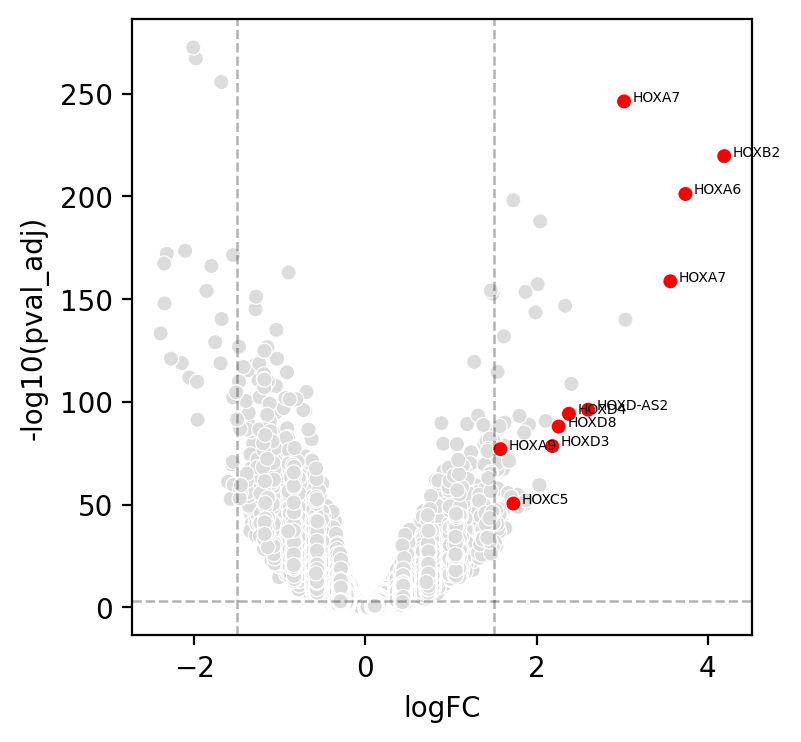

In [96]:
df = pd.read_csv(f"/data/proj/GCB_MK/scCT/nanoCT_EAE/data/variable_peaks/annot_sig_diff_peaks_{ctype}_TRUE_CSCvsBA4_ATAC.bed",sep="\t")
df.rename(columns={df.columns[0]: "PeakID"}, inplace=True)
peak_gene_dict = dict(zip(df["PeakID"], df["Gene Name"]))

df_3["Gene_Name"] = [peak_gene_dict[k] if k in peak_gene_dict.keys() else "" for k in df_3.names]

df_3.loc[opc_csc_var_peaks.logFC >= 15, "logFC"] = 15 #<- leftshifts the outliers
df_3.loc[opc_csc_var_peaks.logFC <= -10, "logFC"] = -10 #<- leftshifts the outliers

df_3["hox_name"] = [x if str(x).startswith("HOX") else "" for x in df_3.Gene_Name]
df_3["fox_name"] = [x if str(x).startswith("FOX") else "" for x in df_3.Gene_Name]

plt.figure(figsize=(4,4))
ax= sns.scatterplot(data=df_3.sort_values(by="is_hox"), x="logFC", y="-log10(pval_adj)", s=30, alpha=1, hue="is_hox", palette=["gainsboro","red"]);
plt.axhline(y=3, alpha=0.3, ls="--", color='black', linewidth=0.9); ## pval_adj cutoff = 0.001
plt.axvline(x=1.5, alpha=0.3, ls="--", color='black', linewidth=0.9);
plt.axvline(x=-1.5, alpha=0.3, ls="--", color='black', linewidth=0.9);

for i in range(70):
    plt.annotate(df_3["hox_name"][i], (df_3["logFC"][i] + 0.1, df_3["-log10(pval_adj)"][i] + 0.1), size=5)

x = len(df_3)
#for i in range(x-5,x):
#    plt.annotate(df_3["Gene_Name"][i], (df_3["logFC"][i], df_3["-log10(pval_adj)"][i] + 0.1), size=7)

#sns.despine();
ax.get_legend().remove()

In [91]:
ax.figure.savefig(f"/data/proj/GCB_MK/scCT/nanoCT_EAE/plots/DiffAcc_{ctype}_TRUE_CSCvBA4_ATAC_HOX_highlighted.svg")

In [157]:
ax.figure.savefig(f"/data/proj/GCB_MK/scCT/nanoCT_EAE/plots/DiffAcc_{ctype}_TRUE_CSCvBA4_ATAC.svg")

In [158]:
ax.figure.savefig(f"/data/proj/GCB_MK/scCT/nanoCT_EAE/plots/DiffAcc_{ctype}_TRUE_CSCvBA4_ATAC.pdf")

In [169]:
adata_main

AnnData object with n_obs × n_vars = 117543 × 100018
    obs: 'NGI_ID', 'NGS_BATCH', 'caseNO', 'Tissue', 'Sex', 'Age', 'PMI', '10X_BATCH', 'nb_features', 'log_nb_features', 'leiden_iter_1', 'leiden_iter_2', 'leiden_iter_3', 'leiden_iter_4', 'annot_rough', 'doublet_scores', 'predicted_doublets', 'ArchR_id', 'is_ArchR_hiQ'
    var: 'n_cells'
    uns: 'annot_rough_colors', 'is_ArchR_hiQ_colors', 'leiden', 'leiden_iter_4_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'normalized_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [170]:
def runTfIdf(
    adata_atac, 
    scale_factor=1e4, 
    copy=False):
    """
    TF-IDF normalization according to MultiVelo
    """
    npeaks = adata_atac.X.sum(1)
    npeaks_inv = scipy.sparse.csr_matrix(1.0/npeaks)
    tf = adata_atac.X.multiply(npeaks_inv)
    idf = scipy.sparse.diags(np.ravel(adata_atac.X.shape[0] / adata_atac.X.sum(0))).log1p()
    if copy:
        adata_atac_copy = adata_atac.copy()
        adata_atac_copy.X = tf.dot(idf) * scale_factor
        return adata_atac_copy
    else:
        adata_atac.X = tf.dot(idf) * scale_factor


In [171]:
runTfIdf(adata_main)

In [172]:
adata_main.layers["normalized_counts"] = adata_main.X.copy()

In [176]:
adata_main

AnnData object with n_obs × n_vars = 117543 × 100018
    obs: 'NGI_ID', 'NGS_BATCH', 'caseNO', 'Tissue', 'Sex', 'Age', 'PMI', '10X_BATCH', 'nb_features', 'log_nb_features', 'leiden_iter_1', 'leiden_iter_2', 'leiden_iter_3', 'leiden_iter_4', 'annot_rough', 'doublet_scores', 'predicted_doublets', 'ArchR_id', 'is_ArchR_hiQ'
    var: 'n_cells'
    uns: 'annot_rough_colors', 'is_ArchR_hiQ_colors', 'leiden', 'leiden_iter_4_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'normalized_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [177]:
annotations = pd.read_csv("/proj/tmp/mukund/MK_atac_RNAannotations.csv", index_col=0)
annotations = annotations.reindex(index=adata_main.obs.index)
#annotations = annotations.reset_index()
annotations

,LS_RNA,MK_ATAC,Nat19_RNA
barcode,,,
AAACTCGGTCTCTGGG-1,Microglia-Macrophages_NA,MIGL1,Immune_cells
AAACTGCAGCTATCCA-1,Neuron_In_NA,OLIGO2,Neuron4
AAAGATGAGGTACTCT-1,Oligo_Oligo_A,OLIGO1,Oligo3
AAATGAGCAAGCTTTG-1,Oligo_Oligo_A,OLIGO1,Oligo2
AACAGTCTCATCGCAA-1,Astrocyte_NA,AST1,Astrocytes
...,...,...,...
TTTGGTTGTGCGACCT-47,Astrocyte_NA,AST1,Astrocytes
TTTGTGTAGAACCATA-47,Neuron_In_NA,MIGL1,Neuron1
TTTGTGTAGGAGAACA-47,Stromal_NA,MIGL2,Pericytes


In [178]:
annotation_dict = dict(zip(annotations.index, zip(annotations.MK_ATAC, annotations.LS_RNA, annotations.Nat19_RNA)))
adata_main.obs["LS_RNA"] = [annotation_dict[k][1] for k in adata_main.obs.index]
adata_main.obs["Nat19_RNA"] = [annotation_dict[k][2] for k in adata_main.obs.index]

# Regional H3K27ac H3K27me3 analysis

In [2]:
import os
import csv
import scipy
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
#import episcanpy.api as epi
#import magic
#import scprep
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import check_random_state
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
import warnings
style.use("default")
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = "retina"
os.chdir("/data/proj/GCB_MK/scCT/nanoCT_EAE/")

In [ ]:
adata